### Курсовая работа. Классическое машинное обучение
### Раздел 3.1. Классификация: превышает ли значение IC50 медианное значение выборки

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:
# Загрузить данные
df = pd.read_csv('ic50.csv')
display(df.head())
print(df.shape)

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM"
0,-1.660292,1.160311,0.838612,-0.700360,1.055009,0.205849,-1.502148,1.494888,-2.031080,-0.565772,...,-0.222073,-0.09245,-0.09245,-0.034816,0.0,-0.259198,-0.272254,2.267263,-0.078039,6.239374
1,-1.993065,2.006622,0.939393,-0.491142,1.237252,0.236943,-1.706545,1.236198,-2.181446,-0.555914,...,-0.222073,-0.09245,-0.09245,-0.034816,0.0,-0.259198,-0.272254,2.267263,-0.078039,0.771831
2,-2.385072,2.060654,0.945827,-1.425902,0.995923,0.685190,-1.061511,1.077899,-2.369403,-0.531481,...,-0.222073,-0.09245,-0.09245,-0.034816,0.0,-0.259198,-0.272254,2.267263,-0.078039,223.808778
3,-1.659333,1.179805,0.840933,-0.883631,0.969976,0.314024,-1.502148,1.494888,-2.124410,-0.565840,...,-0.222073,-0.09245,-0.09245,-0.034816,0.0,-0.259198,-0.272254,3.083280,-0.078039,1.705624
4,-1.643718,0.486530,0.758377,-0.646206,0.543590,0.838696,-1.312738,1.967023,-2.211519,-0.565202,...,-0.222073,-0.09245,-0.09245,-0.034816,0.0,-0.259198,-0.272254,-0.180788,-0.078039,107.131532


(826, 146)


In [4]:
SEED = 42

In [ ]:
# Разделить данные на признаки и целевую переменную
X = df.drop('IC50, mM', axis=1)
y = df['IC50, mM']

# Разделить данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

# Получить медианное значение целевой переменной
MEDIAN = y_train.median()

Train dataset size: (578, 145), (578,)
Train dataset size: (248, 145), (248,)


Условием настоящей задачи является определение, превысит ли значение целевой переменной ее медианное значение. В конечном итоге перед нами стоит задача классификации с двумя возможными метками класса - превысит или нет.

In [12]:
y_train = (y_train > MEDIAN).astype(int)
y_test = (y_test > MEDIAN).astype(int)

C:\Users\Ronikari\AppData\Local\Temp\ipykernel_20192\2910186009.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='IC50, mM', data=y_data, palette='hls')


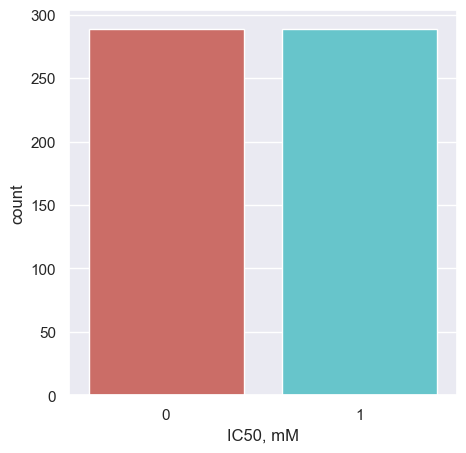

In [171]:
# Проанализировать распределение меток класса
sns.set(rc = {'figure.figsize':(5, 5)})
y_data = pd.DataFrame(y_train)
sns.countplot(x='IC50, mM', data=y_data, palette='hls')
plt.show()

В рамках настоящей задачи будем использовать следующие модели:
- `LogisticRegression`;
- `DecisionTree`;
- `kNN`;
- `RandomForest`;
- `SVC`;
- `XGBoost`;
- `CatBoost`.
  
Для анализа эффективности моделей проверим следующие метрики:
- Accuracy;
- Precision;
- F1;
- Recall.

In [68]:
# Инициализация моделей и метрик
models = {
    'LogisticRegression': LogisticRegression(random_state=SEED),
    'DecisionTree': DecisionTreeClassifier(random_state=SEED),
    'RandomForest': RandomForestClassifier(random_state=SEED),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(random_state=SEED),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=SEED),
    'CatBoost': CatBoostClassifier(random_state=SEED, verbose=False)
}
metrics = {
    'Accuracy': lambda y_true, y_pred: accuracy_score(y_true, y_pred),
    'Precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'),
    'F1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    'Recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary')
}

In [69]:
# Создать список для хранения результатов
results = []

In [ ]:
for name, model in models.items():
    # Осуществить стратифицированную k-кратную перекрестную проверку
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=1)
    cv_precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision', n_jobs=1)
    cv_f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=1)
    cv_recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall', n_jobs=1)
    
    # Обучить модель на обучающей выборке и сделать прогноз на тестовой выборке
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    test_accuracy = metrics['Accuracy'](y_test, y_pred)
    test_precision = metrics['Precision'](y_test, y_pred)
    test_f1 = metrics['F1'](y_test, y_pred)
    test_recall = metrics['Recall'](y_test, y_pred)
    
    # Сохранить результаты
    results.append({
        'Model': name,
        'CV Accuracy': cv_accuracy.mean(),
        'CV Precision': cv_precision.mean(),
        'CV F1': cv_f1.mean(),
        'CV Recall': cv_recall.mean(),
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test F1': test_f1,
        'Test Recall': test_recall
    })

In [71]:
# Записать результаты в DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)
display(results_df.round(4))

,Model,CV Accuracy,CV Precision,CV F1,CV Recall,Test Accuracy,Test Precision,Test F1,Test Recall
2,RandomForest,0.6471,0.6560,0.6398,0.6300,0.7137,0.6694,0.7004,0.7345
6,CatBoost,0.6610,0.6675,0.6570,0.6507,0.6895,0.6385,0.6831,0.7345
5,XGBoost,0.6610,0.6679,0.6563,0.6472,0.6815,0.6371,0.6667,0.6991
4,SVC,0.6419,0.6591,0.6217,0.5920,0.6613,0.6218,0.6379,0.6549
1,DecisionTree,0.5952,0.6092,0.5682,0.5327,0.6613,0.6179,0.6441,0.6726
0,LogisticRegression,0.6142,0.6177,0.6102,0.6057,0.6573,0.6077,0.6502,0.6991
3,KNN,0.6368,0.6420,0.6297,0.6195,0.6290,0.5814,0.6198,0.6637


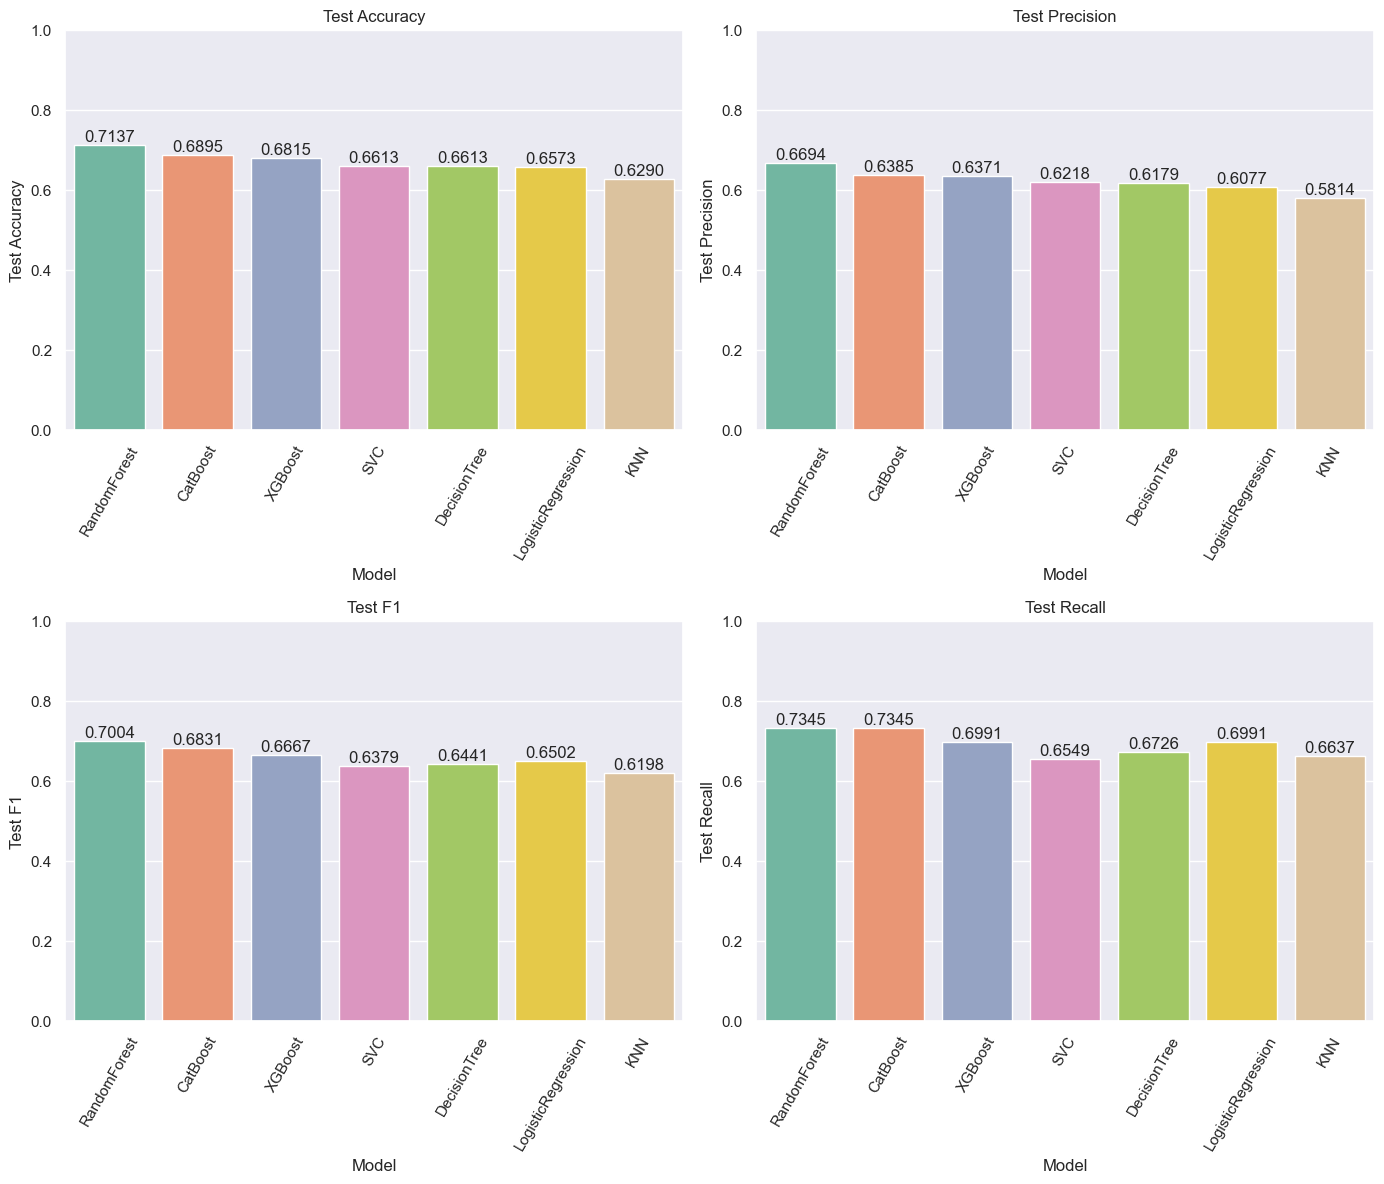

In [172]:
# Визуализация полученных метрик
plt.figure(figsize=(14, 12))
for i, metric in enumerate(list(metrics.keys())):
    plt.subplot(2, 2, i + 1)
    ax = sns.barplot(x='Model', y=f'Test {metric}', data=results_df, palette="Set2", hue='Model', legend=False)
    [ax.bar_label(ax.containers[x], fmt='%.4f', fontsize=12) for x in range(0, len(list(models.keys())))]
    plt.title(f'Test {metric}')
    plt.ylim(0.0, 1.0)
    plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

По совокупности полученных метрик наиболее эффективной моделью является `RandomForest`.   
Теперь используем `GridSearchCV` и подберем наиболее оптимальные гиперпараметры для всех моделей, после чего перепроверим метрики.

In [87]:
# Конфигурация гиперпараметров для GridSearchCV
params = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 250, 500, 1000]
    },
    'DecisionTree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300, 400, 500, 1000],
        'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'SVC': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300, 400, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'max_depth': [None, 5, 10, 20]
    },
    'CatBoost': {
        'n_estimators': [50, 100, 200, 400, 500, 1000]
    }
}

# Повторная инициализация моделей
models = {
    'LogisticRegression': LogisticRegression(random_state=SEED),
    'DecisionTree': DecisionTreeClassifier(random_state=SEED),
    'RandomForest': RandomForestClassifier(random_state=SEED),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(random_state=SEED),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=SEED),
    'CatBoost': CatBoostClassifier(random_state=SEED, verbose=False)
}

In [154]:
# Создать список для хранения результатов
results_grid = []

# Создать словарь для хранения предсказанных значений
pred_values = {}

In [155]:
for name, model in models.items():
    # Запустить поиск лучших гиперпараметров
    grid = GridSearchCV(model, param_grid=params[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Лучшая модель
    best_model = grid.best_estimator_
    print(f'Лучшие параметры для {name}: {grid.best_params_}')
    
    # Осуществить стратифицированную k-кратную перекрестную проверку
    cv_accuracy = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=1)
    cv_precision = cross_val_score(best_model, X_train, y_train, cv=5, scoring='precision', n_jobs=1)
    cv_f1 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1', n_jobs=1)
    cv_recall = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall', n_jobs=1)
    
    # Обучить и оценить качество лучшей модели на тестовой выборке
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    pred_values[name] = y_pred
    
    test_accuracy = metrics['Accuracy'](y_test, y_pred)
    test_precision = metrics['Precision'](y_test, y_pred)
    test_f1 = metrics['F1'](y_test, y_pred)
    test_recall = metrics['Recall'](y_test, y_pred)
    
    # Сохранить результаты
    results_grid.append({
        'Model': name,
        'CV Accuracy': cv_accuracy.mean(),
        'CV Precision': cv_precision.mean(),
        'CV F1': cv_f1.mean(),
        'CV Recall': cv_recall.mean(),
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test F1': test_f1,
        'Test Recall': test_recall
    })

Лучшие параметры для LogisticRegression: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Лучшие параметры для DecisionTree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Лучшие параметры для RandomForest: {'max_depth': 4, 'n_estimators': 400}
Лучшие параметры для KNN: {'metric': 'manhattan', 'n_neighbors': 3}
Лучшие параметры для SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Лучшие параметры для XGBoost: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
Лучшие параметры для CatBoost: {'n_estimators': 500}


In [169]:
# Записать результаты в DataFrame
results_grid_df = pd.DataFrame(results_grid)
results_grid_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)
display(results_grid_df.round(4))

,Model,CV Accuracy,CV Precision,CV F1,CV Recall,Test Accuracy,Test Precision,Test F1,Test Recall
5,XGBoost,0.6835,0.6897,0.6819,0.6783,0.7056,0.6639,0.6894,0.7168
6,CatBoost,0.6713,0.6769,0.6690,0.6645,0.6976,0.6508,0.6862,0.7257
2,RandomForest,0.6627,0.6738,0.6540,0.6403,0.6774,0.6260,0.6721,0.7257
4,SVC,0.6523,0.6624,0.6429,0.6264,0.6694,0.6220,0.6583,0.6991
3,KNN,0.6437,0.6522,0.6325,0.6160,0.6694,0.6325,0.6435,0.6549
0,LogisticRegression,0.6332,0.6335,0.6375,0.6437,0.6492,0.6000,0.6420,0.6903
1,DecisionTree,0.6593,0.6658,0.6540,0.6472,0.6452,0.6033,0.6239,0.6460


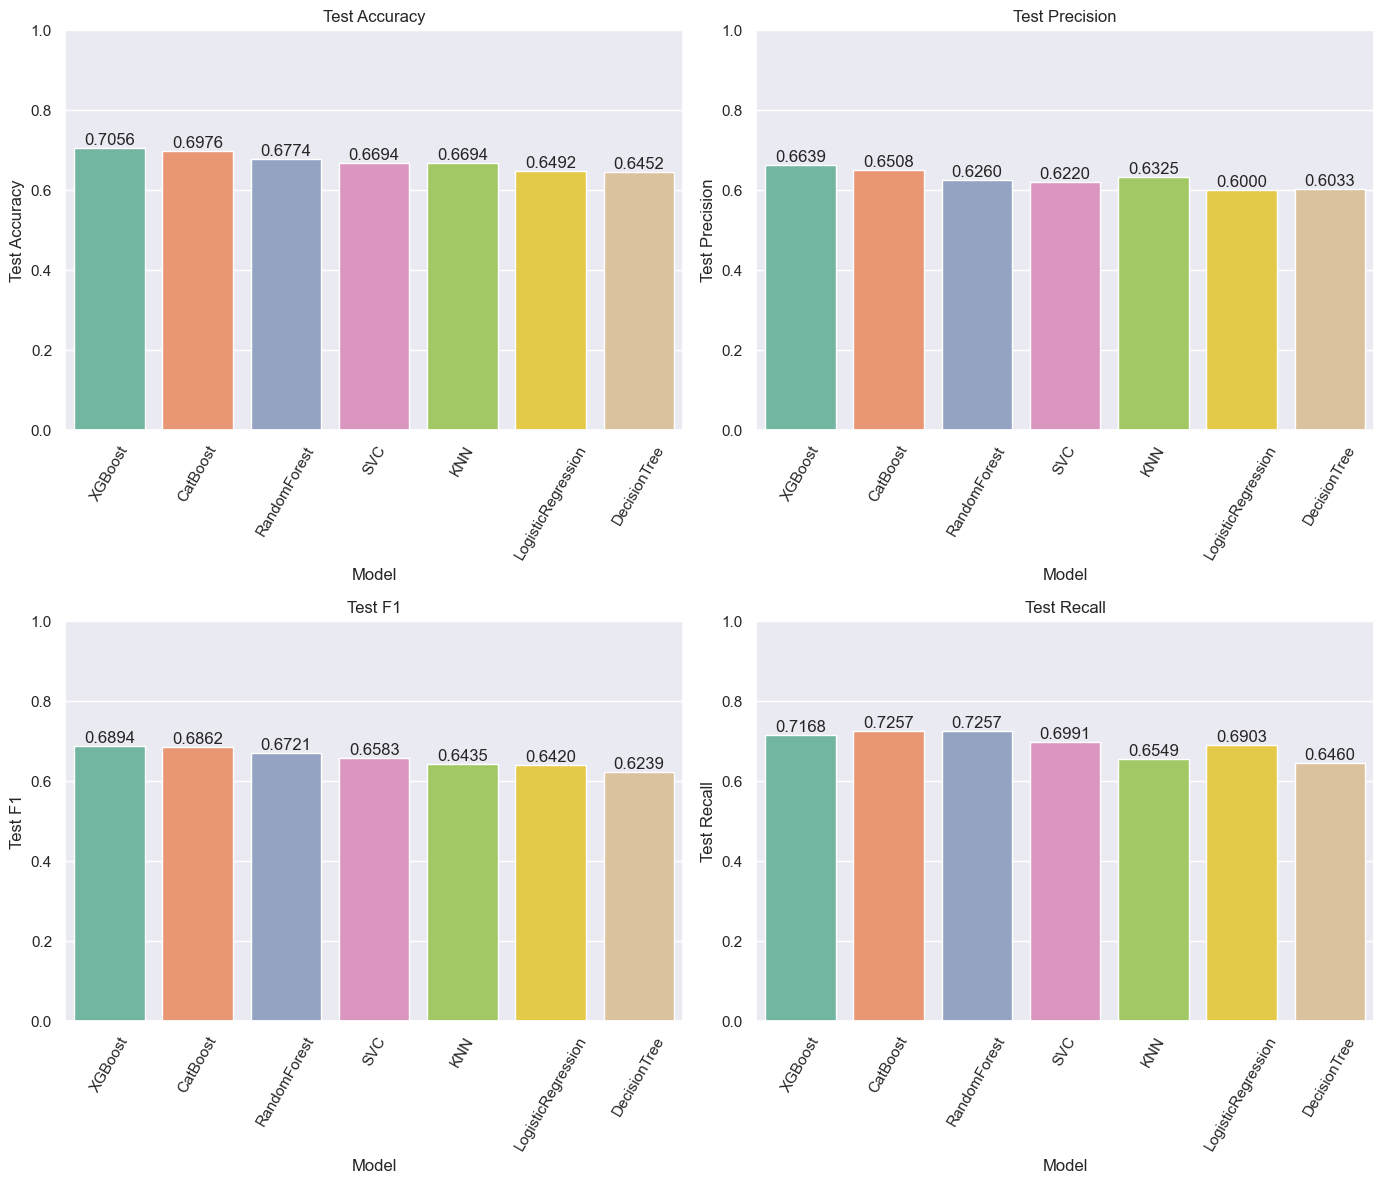

In [173]:
# Визуализация полученных метрик
plt.figure(figsize=(14, 12))
for i, metric in enumerate(list(metrics.keys())):
    plt.subplot(2, 2, i + 1)
    ax = sns.barplot(x='Model', y=f'Test {metric}', data=results_grid_df, palette="Set2", hue='Model', legend=False)
    [ax.bar_label(ax.containers[x], fmt='%.4f', fontsize=12) for x in range(0, len(list(models.keys())))]
    plt.title(f'Test {metric}')
    plt.ylim(0.0, 1.0)
    plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

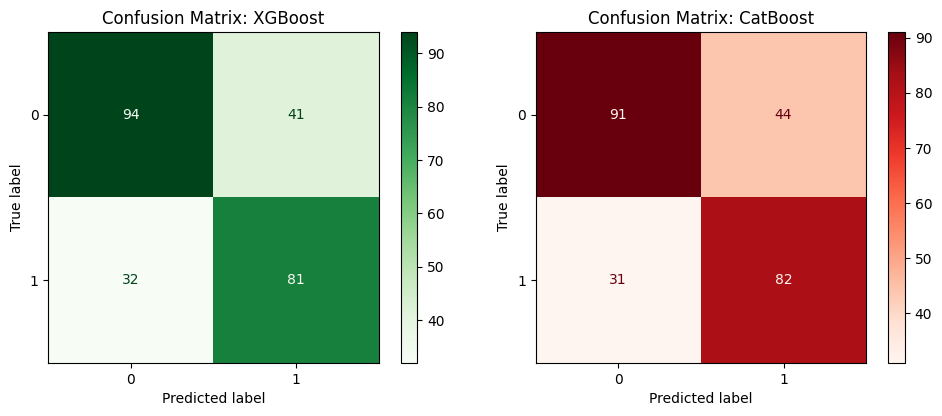

In [ ]:
# Построить матрицы ошибок для лучших моделей
cm_xgb = confusion_matrix(y_test, pred_values['XGBoost'])
cm_cat = confusion_matrix(y_test, pred_values['CatBoost'])

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
cm_display = ConfusionMatrixDisplay(cm_xgb)
cm_display.plot(ax=axes[0], cmap='Greens')
cm_display = ConfusionMatrixDisplay(cm_cat)
cm_display.plot(ax=axes[1], cmap='Reds')

axes[0].set_title('Confusion Matrix: XGBoost')
axes[1].set_title('Confusion Matrix: CatBoost')

plt.tight_layout()
plt.show()

По совокупности полученных метрик и с подбором гиперпараметров посредством `GridSearchCV` наиболее эффективными моделями являются `XGBoost` и `CatBoost`.   

**Выводы**  
  
1. В рамках настоящей задачи были использованы следующие модели:
- `LogisticRegression`;
- `DecisionTree`;
- `kNN`;
- `RandomForest`;
- `SVC`;
- `XGBoost`;
- `CatBoost`.
  
   Наиболее оптимальными моделями по совокупности использованных метрик принимаются `XGBoost` и `CatBoost`.
2. Метрики всех моделей оказались приемлемыми. В качестве рекомендаций по дальнейшему улучшению предсказательной способности моделей требуется более глубокая обработка исходных данных. Как показал ранее выполненный EDA, в данных присутствует существенное число выбросов, однако для их эффективного устранения требуется знание специфики отрасли и понимание ключевой важности тех или иных признаков, что не было выполнено в настоящей работе.